# Seminar in Climatology


The current extreme heat is due to an anticyclone, a high-pressure system, that is dominating the upper atmosphere over southern Europe. As well as compressing and warming air, high-pressure systems are associated with reduced cloud cover, allowing more solar radiation to reach the ground. This allows for substantial heating of Earth’s surface by the sun, heat which then moves upwards into the atmosphere. The long days and short nights of summer mean that this heating effect is maximised. (Copernicus)

Large scale winds, advection, blowing hot air for example from northern Africa into Europe, can also contribute to heatwaves. For the current heatwave this factor seems to be less important. (Copernicus)

In [105]:
# General libs for file paths, data extraction, etc
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile # To extract zipfiles
import urllib3 
urllib3.disable_warnings() # Disable warnings for data download via API

# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import xarray.plot as xplot
import pandas as pd

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from datetime import datetime

# ERA-5

In [106]:
ERA_data = xr.open_dataset('../data/ERA_data_july_heatwaves.nc')
ERA_data.variables

Frozen({'u10': <xarray.Variable (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Attributes:
    long_name:  10 metre U wind component
    units:      m s**-1, 'v10': <xarray.Variable (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Attributes:
    long_name:  10 metre V wind component
    units:      m s**-1, 'msl': <xarray.Variable (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Attributes:
    standard_name:  air_pressure_at_mean_sea_level
    long_name:      Mean sea level pressure
    units:          Pa, 't2m': <xarray.Variable (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Attributes:
    long_name:  2 metre temperature
    units:      K, 'd2m': <xarray.Variable (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Attributes:
    long_name:  2 metre dewpoint temperature
    units:      K, 'sp': <xarray.Variable (time: 68, l

In [108]:
ERA_data.dims

FrozenMappingWarningOnValuesAccess({'time': 68, 'lat': 121, 'lon': 1440, 'level': 2})

In [109]:
ERA_data['t2m']

<xarray.DataArray 't2m' (time: 68, lat: 121, lon: 1440)> Size: 47MB
[11848320 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 544B 2023-07-01 ... 2023-07-17T18:00:00
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 484B 20.0 20.25 20.5 20.75 ... 49.25 49.5 49.75 50.0
Attributes:
    long_name:  2 metre temperature
    units:      K

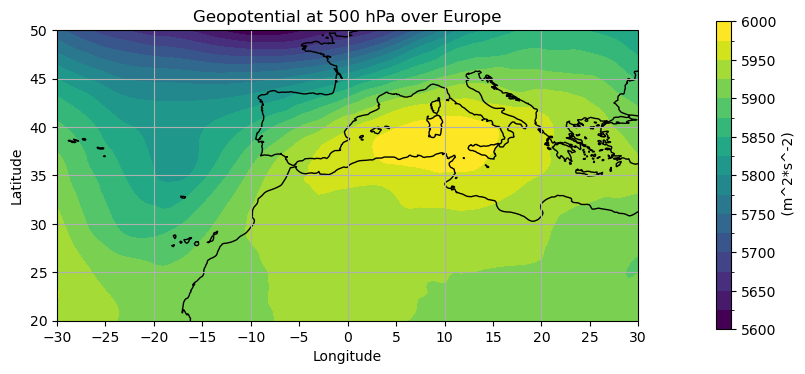

In [110]:
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Select the geopotential data for the 500 hPa level and the specified longitude and latitude ranges
z_500hPa_sliced = (ERA_data['z'].sel(level=500, lon=lon_range, lat=lat_range))

# Divide by the gravitational acceleration (9.81)
z_500hPa = z_500hPa_sliced/9.81

# Plot the geopotential at 500 hPa on a map
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
z_500hPa.isel(time=64).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                                            cmap='viridis', levels=20, 
                                            cbar_kwargs={'label': ' (m^2*s^-2)', 'pad': 0.1})

# Add coastlines and gridlines
ax.coastlines()
ax.gridlines()

# Add latitude and longitude labels to the axes
plt.xticks(range(-30, 31, 5))  # Adjust step size as needed
plt.yticks(range(20, 51, 5))  # Adjust step size as needed

# Add title and labels
plt.title('Geopotential at 500 hPa over Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the
plt.show()

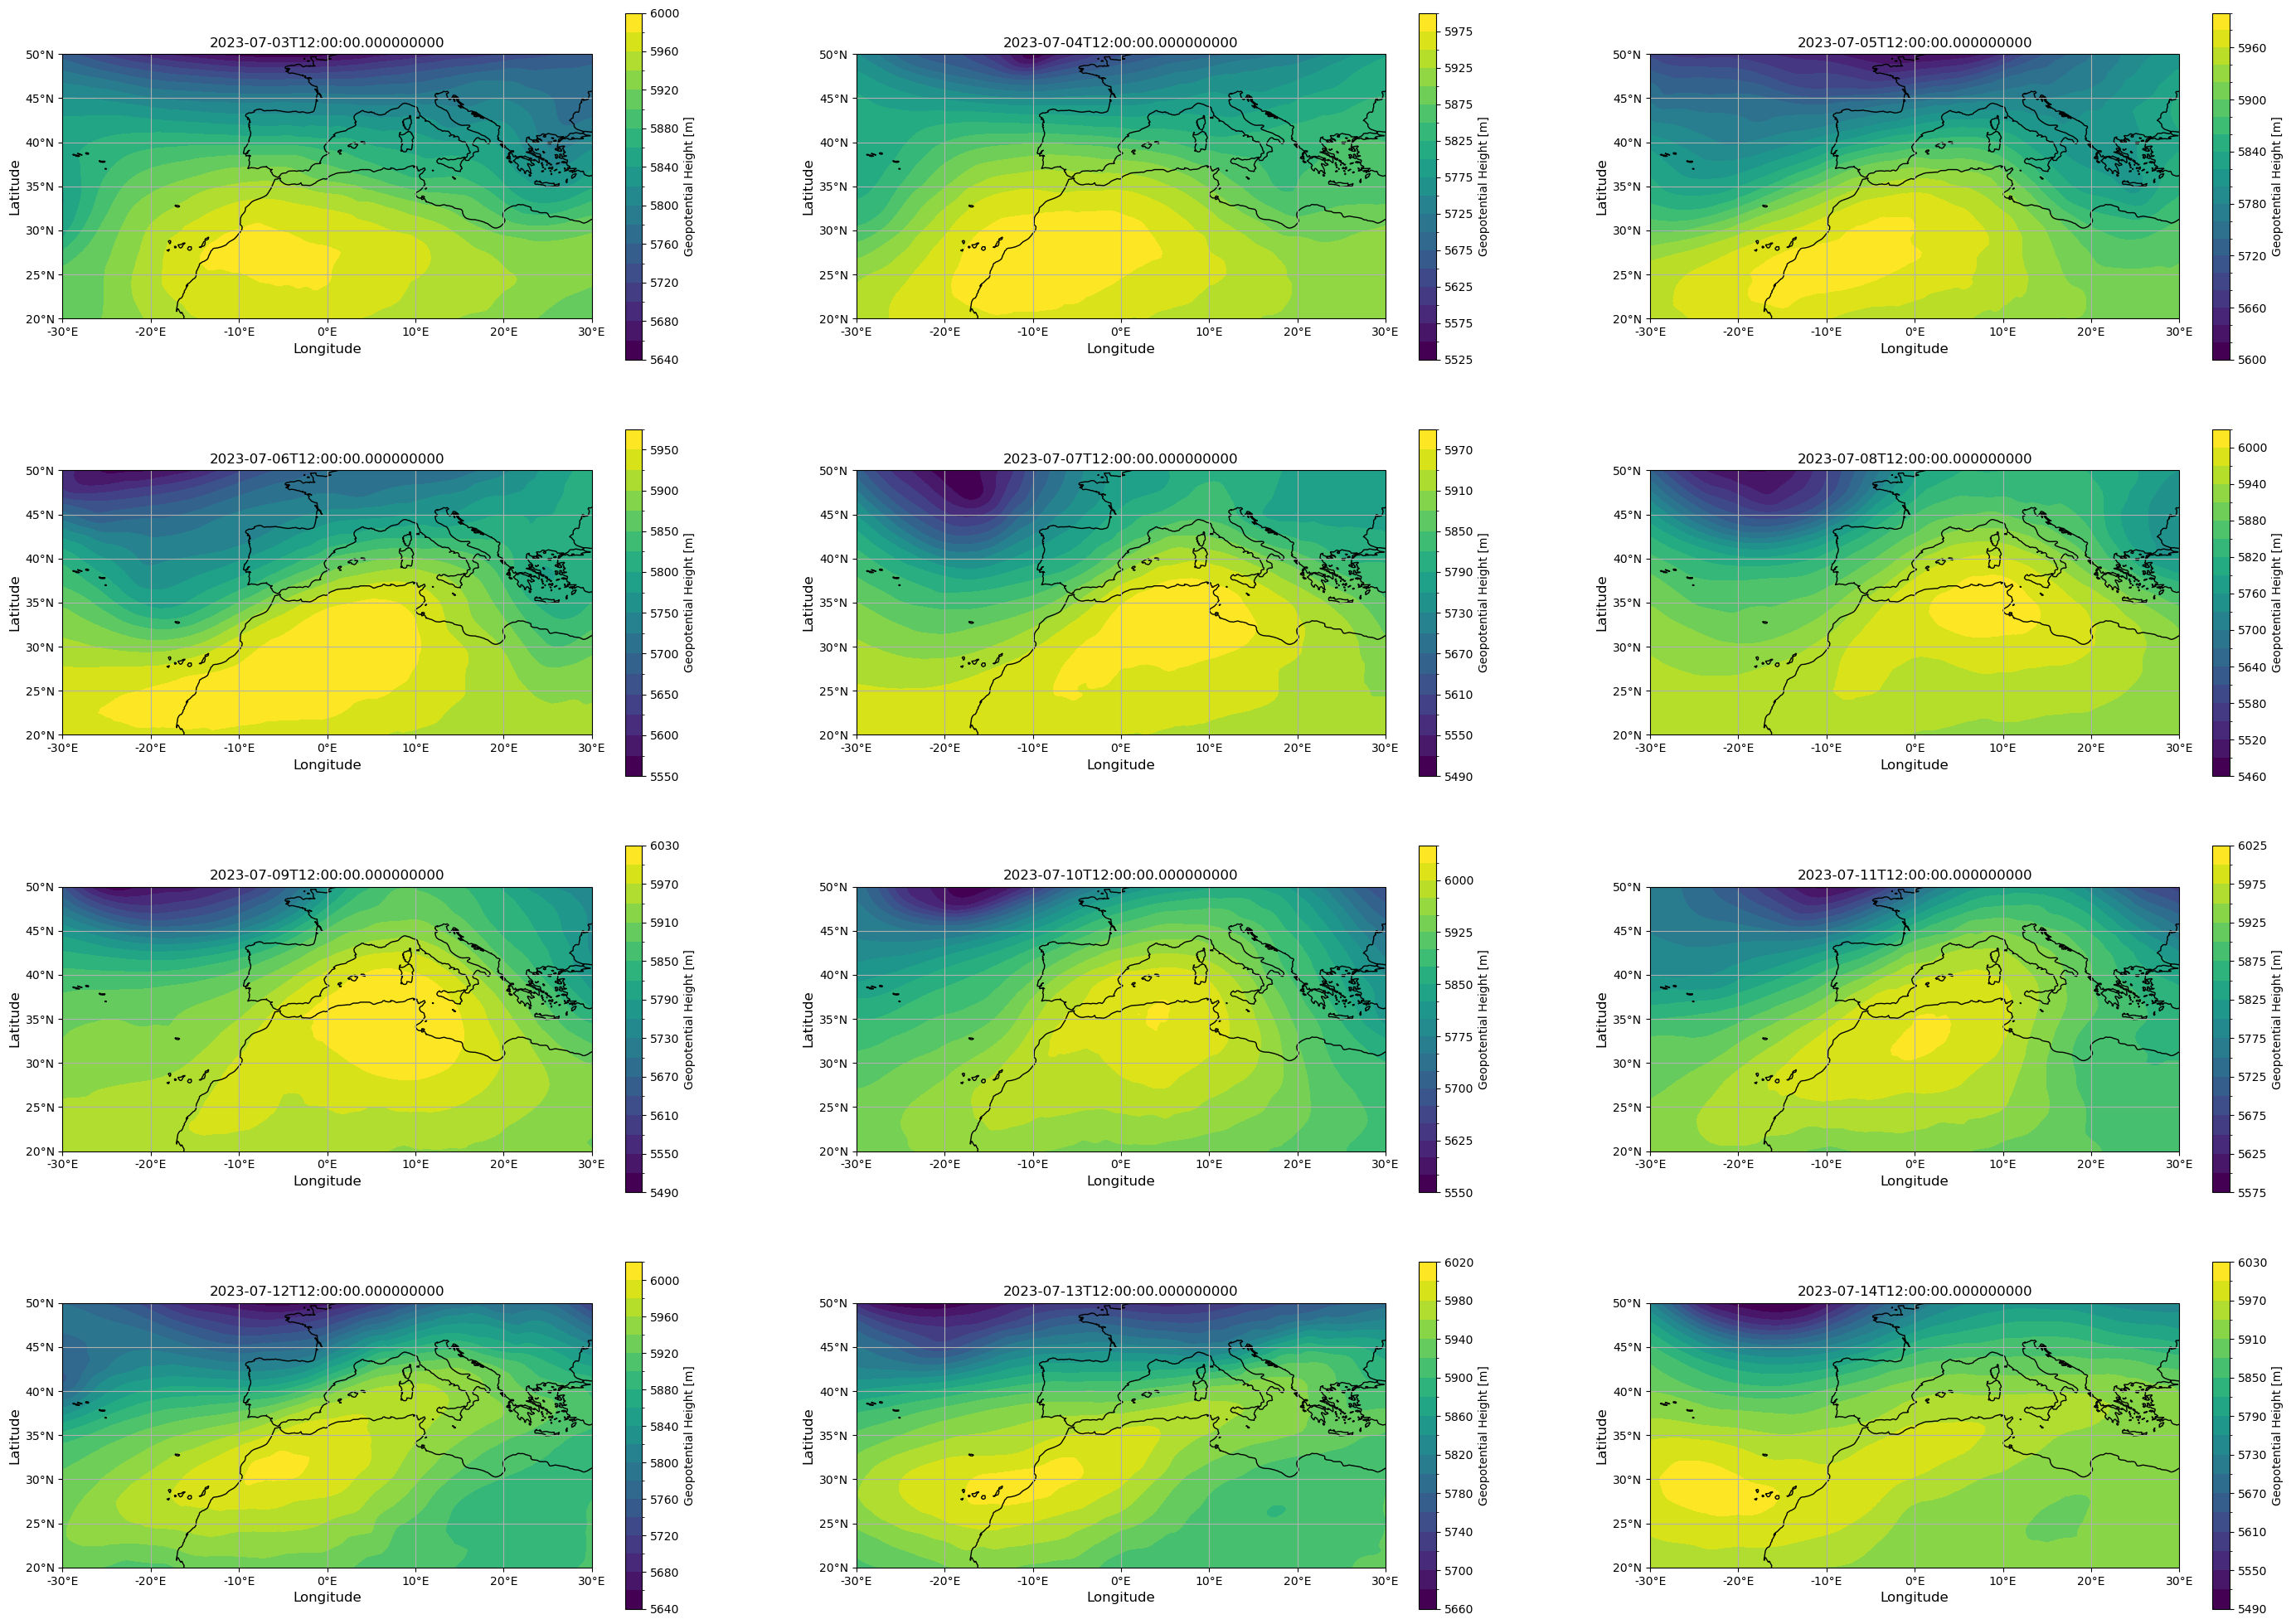

In [134]:
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Select the geopotential data for the 500 hPa level and the specified longitude and latitude ranges
z_500hPa_sliced = ERA_data['z'].sel(level=500, lon=lon_range, lat=lat_range)/9.81

# Select specific timesteps (for example, every second timestep from the first 4 timesteps)
selected_timesteps = z_500hPa_sliced['time'].isel(time=slice(10, 68, 4))

# Plot the 2-meter temperature for the selected timesteps
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(35, 25), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = z_500hPa_sliced.sel(time=selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    xplot.contourf(plot_data, ax=ax, cmap='viridis', levels=20, cbar_kwargs={'label': 'Geopotential Height [m]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(rounded_time.values, fontsize=12)  # Set the title with rounded time values

# Save the plot as a PNG file
plt.savefig('../analysis/ERA_geopot.pdf')
# Show the plot
plt.show()

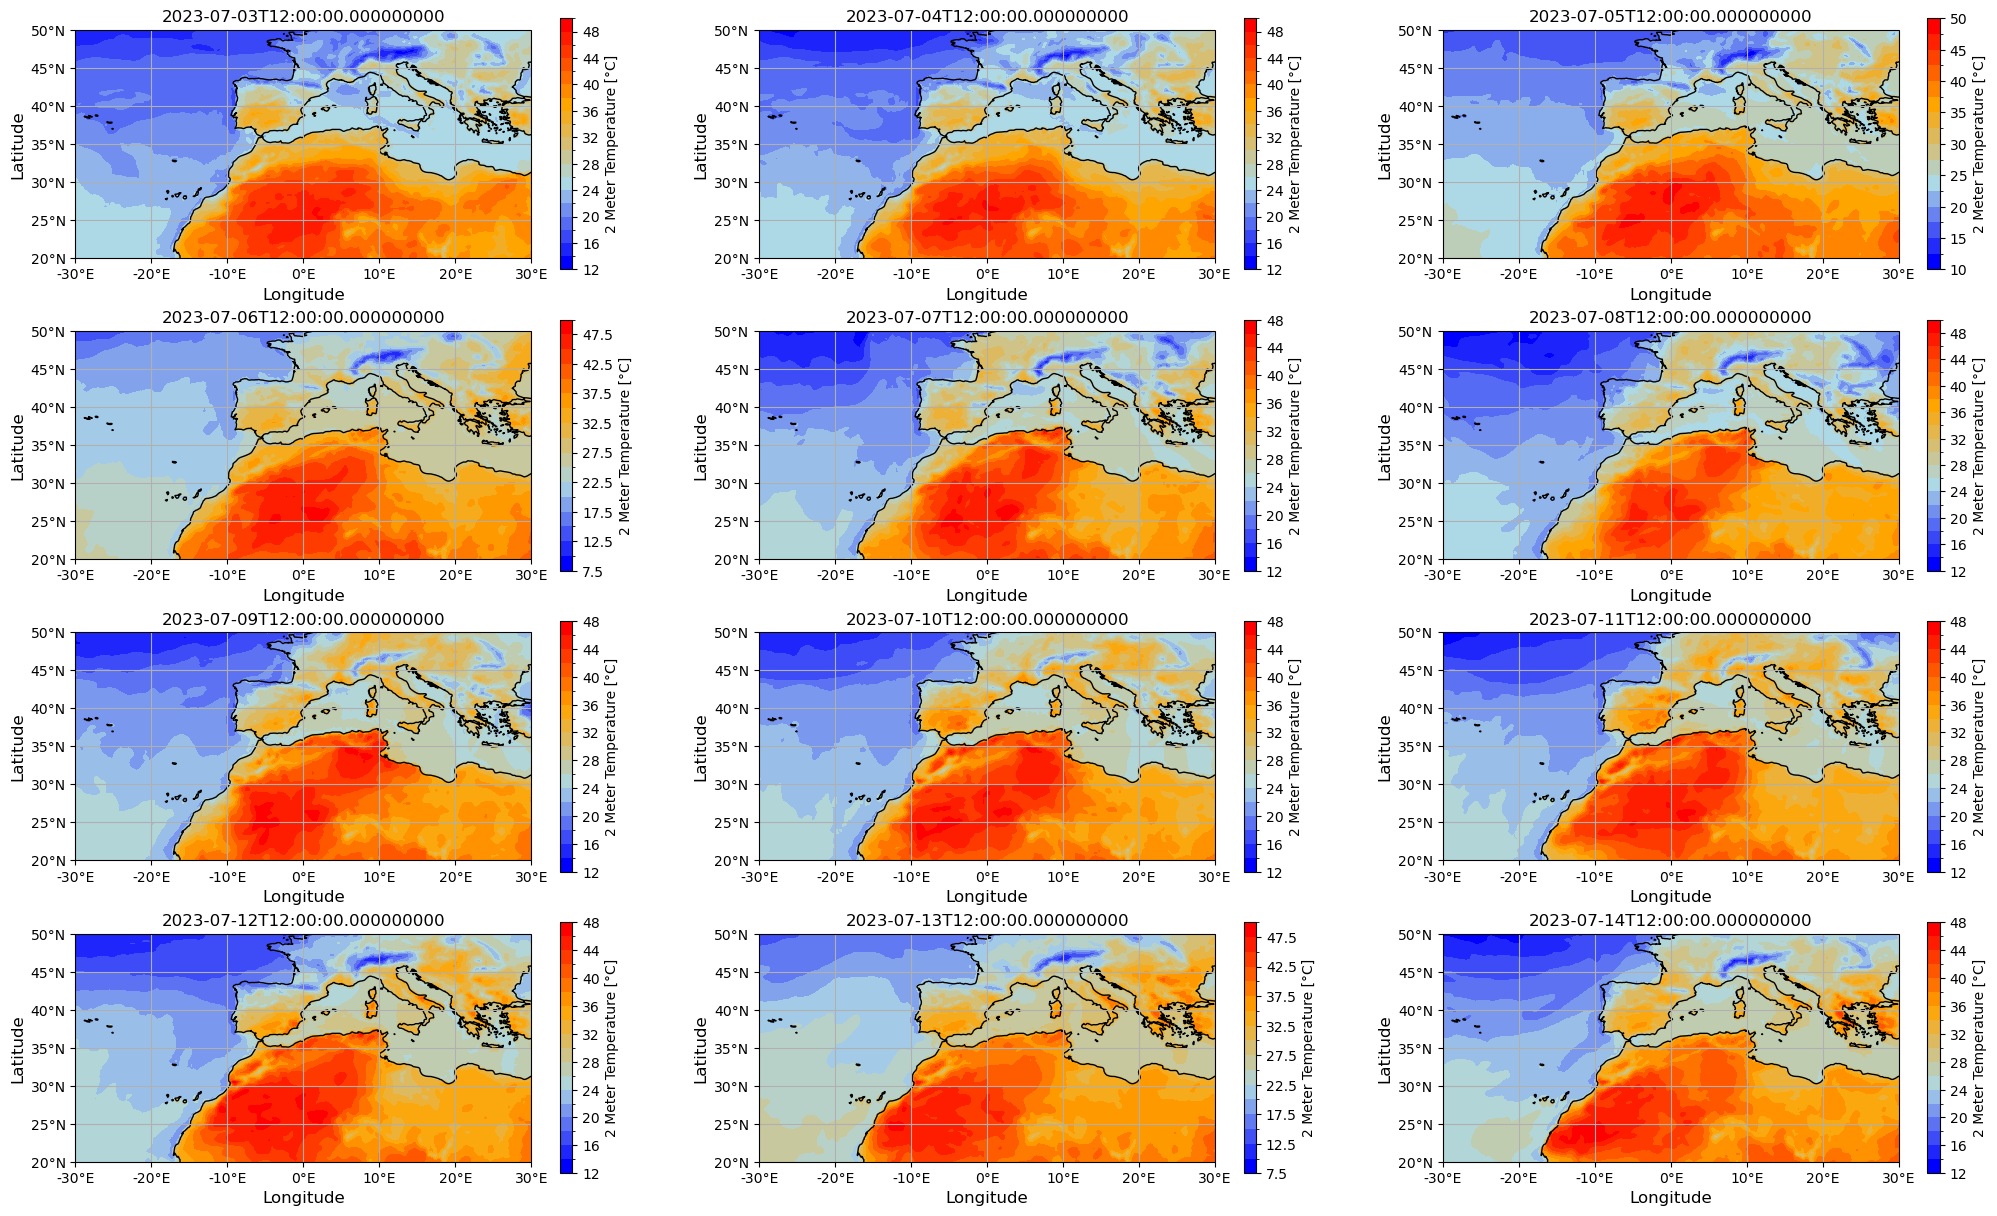

In [121]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'lightblue', 'orange', 'red'])

# Define the longitude and latitude ranges
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2m_sliced = ERA_data['t2m'].sel(lon=lon_range, lat=lat_range)-273.15

# Select specific timesteps
t2m_selected_timesteps = t2m_sliced['time'].isel(time=slice(10, 68, 4))

# Plot the 2-meter temperature for the selected timesteps
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = t2m_sliced.sel(time=t2m_selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    xplot.contourf(plot_data, ax=ax, cmap=cmap, levels=20, cbar_kwargs={'label': '2 Meter Temperature [°C]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(rounded_time.values, fontsize=12)  # Set the title with rounded time values

# Save the plot as a PNG file
plt.savefig('../analysis/ERA_t2m.pdf')

# Show the plot
plt.show()

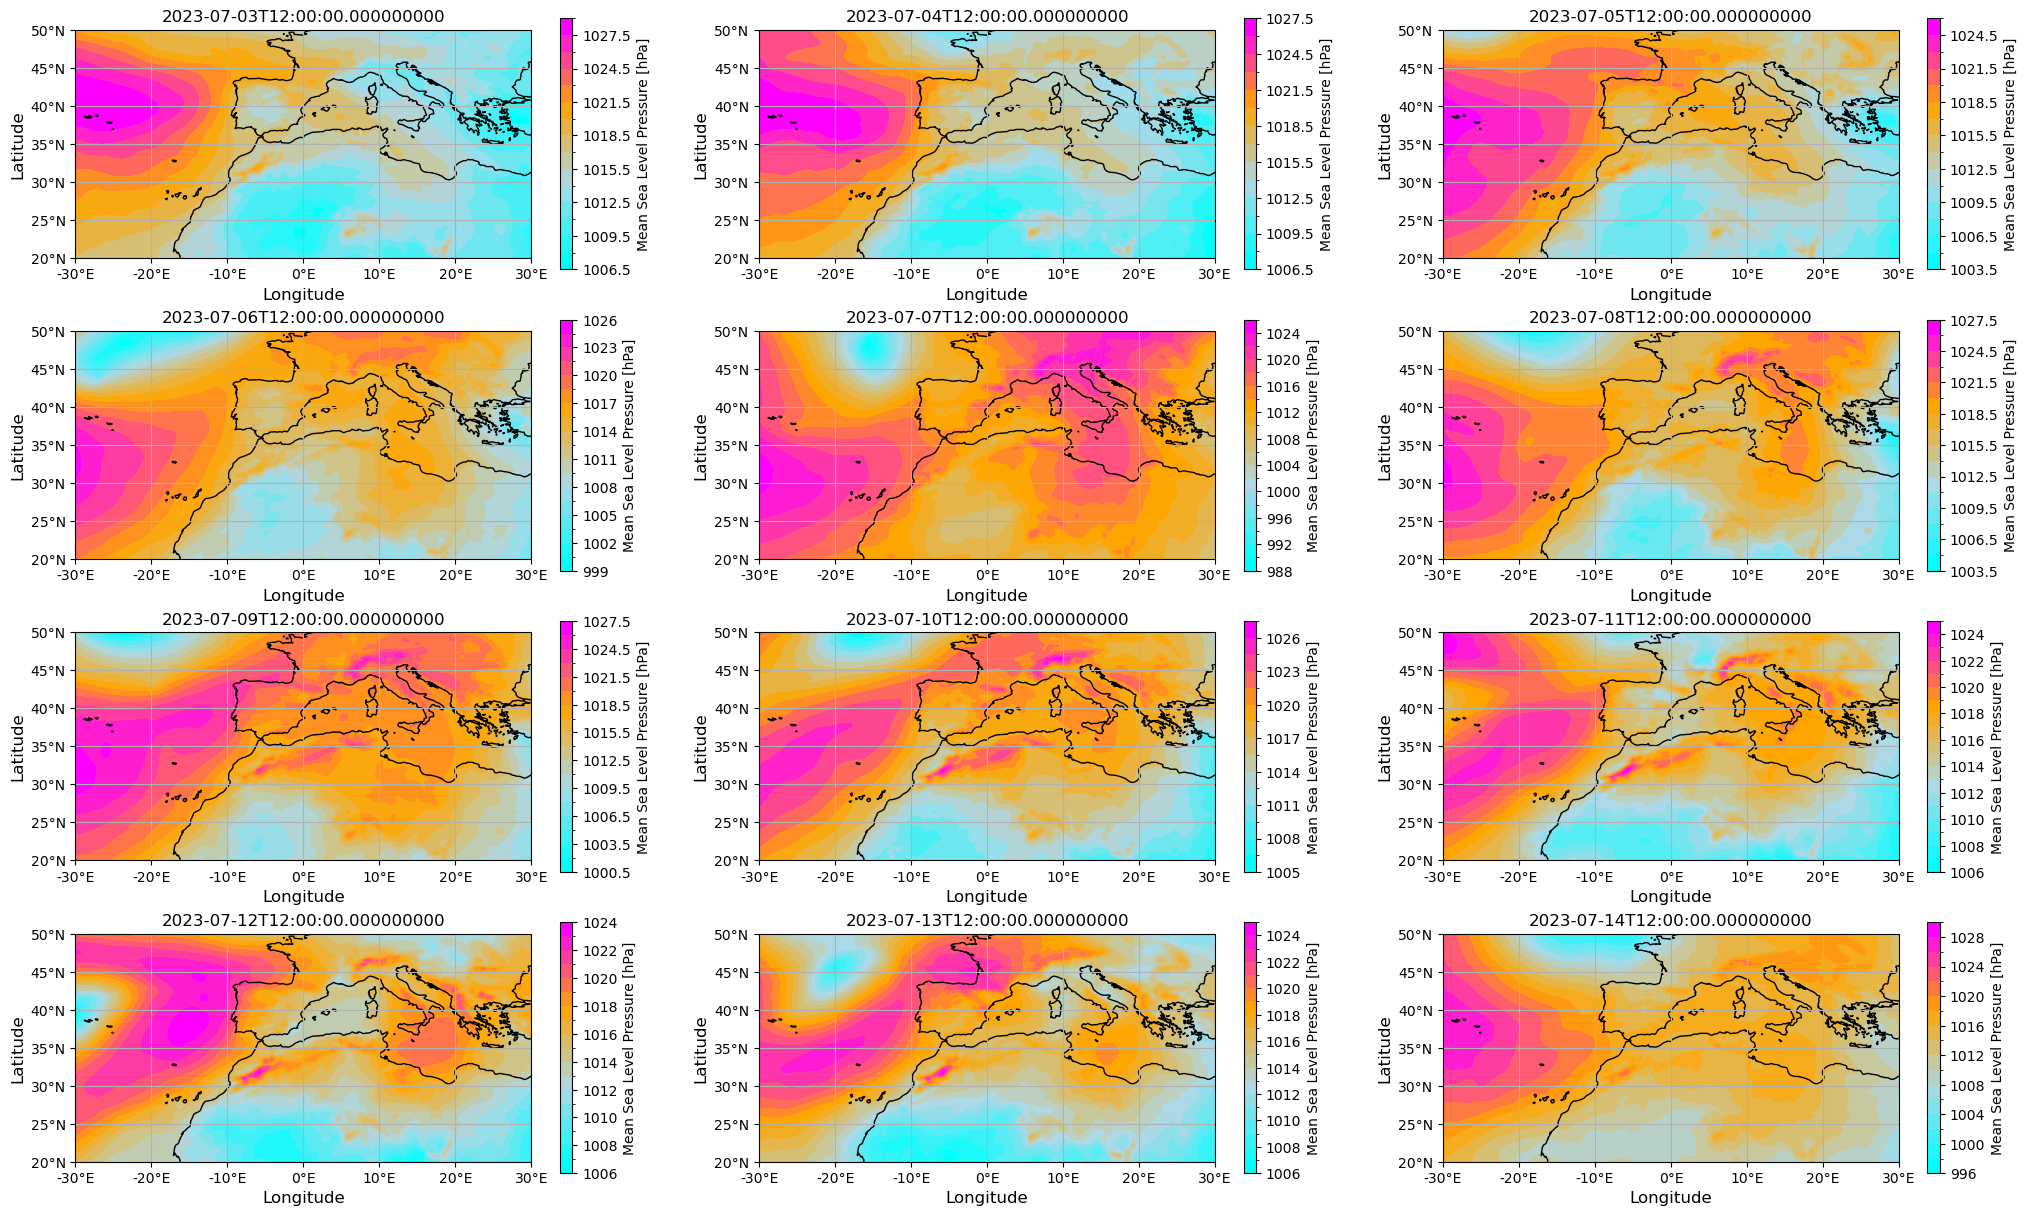

In [123]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['cyan', 'lightblue', 'orange', 'magenta'])

# Define the longitude and latitude ranges
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Select the 2-meter temperature data for the specified longitude and latitude ranges
mslp_sliced = ERA_data['msl'].sel(lon=lon_range, lat=lat_range)/100

# Select specific timesteps
mslp_selected_timesteps = mslp_sliced['time'].isel(time=slice(10, 68, 4))

# Plot the 2-meter temperature for the selected timesteps
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = mslp_sliced.sel(time=t2m_selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    xplot.contourf(plot_data, ax=ax, cmap=cmap, levels=20, cbar_kwargs={'label': 'Mean Sea Level Pressure [hPa]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{lat}°N' for lat in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{lon}°E' for lon in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(rounded_time.values, fontsize=12)  # Set the title with rounded time values

# Save the plot as a PNG file
plt.savefig('../analysis/ERA_msl.pdf')
# Show the plot
plt.show()

# Pangu-Weather

In [9]:
# Data 2.7.2023
Pangu_data_20230702 = xr.open_dataset('../data/HW_EU_20230702.nc')

# Data .7.2023
Pangu_data_20230707 = xr.open_dataset('../data/HW_EU_20230707.nc')

# Data 2.7.2023
Pangu_data_20230711 = xr.open_dataset('../data/HW_EU_20230711.nc')

In [10]:
Pangu_data_20230702.dims

FrozenMappingWarningOnValuesAccess({'longitude': 1440, 'latitude': 121, 'step': 14, 'isobaricInhPa': 2})

In [16]:
Pangu_data_20230702_sliced = (Pangu_data_20230702 ['t2'])
Pangu_data_20230702_sliced

<xarray.DataArray 't2' (step: 14, latitude: 121, longitude: 1440)> Size: 10MB
[2439360 values with dtype=float32]
Coordinates:
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * latitude           (latitude) float64 968B 50.0 49.75 49.5 ... 20.25 20.0
  * step               (step) timedelta64[ns] 112B 9 days 18:00:00 ... 13 day...
    valid_time         (step) datetime64[ns] 112B ...
    time               datetime64[ns] 8B ...
    meanSea            float64 8B ...
    heightAboveGround  float64 8B ...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

In [12]:
Pangu_data_20230702.variables

Frozen({'longitude': <xarray.IndexVariable 'longitude' (longitude: 1440)> Size: 12kB
array([0.0000e+00, 2.5000e-01, 5.0000e-01, ..., 3.5925e+02, 3.5950e+02,
       3.5975e+02])
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude, 'latitude': <xarray.IndexVariable 'latitude' (latitude: 121)> Size: 968B
array([50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
       47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
       45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
       42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25,
       35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 , 30.25,
       30.  , 29.75, 29.5 , 

In [39]:


# Select the 2-meter temperature data for the specified longitude and latitude ranges
msl_sliced = Pangu_data_20230702['t2']
msl_sliced



<xarray.DataArray 't2' (step: 14, latitude: 121, longitude: 1440)> Size: 10MB
[2439360 values with dtype=float32]
Coordinates:
  * longitude          (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
  * latitude           (latitude) float64 968B 50.0 49.75 49.5 ... 20.25 20.0
  * step               (step) timedelta64[ns] 112B 9 days 18:00:00 ... 13 day...
    valid_time         (step) datetime64[ns] 112B ...
    time               datetime64[ns] 8B ...
    meanSea            float64 8B ...
    heightAboveGround  float64 8B ...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1038240
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

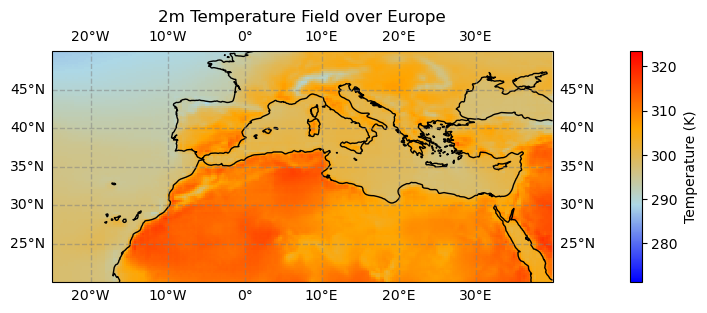

In [47]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'lightblue', 'orange', 'red'])

# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2 = Pangu_data_20230702['t2']

# Extract the temperature variable(time _ 0-8759 --> 24h*365d)
temperature = Pangu_data_20230702.t2[13,:,:]

# Create a plot with a map of Europe
plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot temperature field
temperature.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature (K)', 'pad': 0.1})
ax.coastlines(resolution='50m')  # Add coastlines
ax.set_extent([-25, 40, 20, 50], crs=ccrs.PlateCarree())  # Set the map extent to Europe
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.title('2m Temperature Field over Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [104]:
# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2m_selected = Pangu_data_20230702['t2']-273.15
# Define the longitude ranges using boolean indexing
t2m_selected_sliced = (t2m_selected['longitude'] >= 330) | (Pangu_data_20230702['longitude'] <= 30)
lat_range = slice(20, 50)

# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2 = t2m_selected_sliced.sel(latitude=lat_range)-273.15

print(t2)

KeyError: "'latitude' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'longitude': 1440})"

In [101]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'lightblue', 'orange', 'red'])

# Define the longitude ranges using boolean indexing
Pangu = (Pangu_data_20230702['longitude'] >= 330) | (Pangu_data_20230702['longitude'] <= 30)
lat_range = slice(20, 50)

# Select the 2-meter temperature data for the specified longitude and latitude ranges
t2m_selected = Pangu['t2'].sel(lat=lat_range)-273.15

# Select the 2-meter temperature data for the specified longitude ranges and concatenate them along the longitude dimension
t2m_selected = xr.concat([Pangu_data_20230702['t2'].sel(longitude=lon_range), Pangu_data_20230702['t2'].sel(longitude=lon_range_extended)], dim='longitude')

# Select specific timesteps
t2_selected_timesteps = t2_selected['step'].isel(step=slice(0, 4))

# Plot the 2-meter temperature for the selected timesteps
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 15), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axes.flat):
    plot_data = t2_selected.sel(step = t2_selected_timesteps[i])
    rounded_time = plot_data.time.dt.round('min')  # Round the time values to the nearest minute
    xplot.contourf(plot_data, ax=ax, cmap=cmap, levels=20, cbar_kwargs={'label': '2 Meter Temperature [m]'})
    ax.coastlines()
    ax.gridlines(draw_labels=False)  # Draw gridlines only for the bottom and left axes
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_yticks(range(20, 51, 5))  # Add explicit ticks for the y-axis
    ax.set_yticklabels([f'{latitude}°N' for latitude in range(20, 51, 5)], fontsize=10)  # Add explicit labels for the y-axis
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_xticks(np.arange(-30, 31, 10))  # Add explicit ticks for the x-axis with 10 degree step
    ax.set_xticklabels([f'{longitude}°E' for longitude in np.arange(-30, 31, 10)], fontsize=10)  # Add explicit labels for the x-axis
    ax.set_title(rounded_time.values, fontsize=12)  # Set the title with rounded time values

# Show the plot
plt.show()

KeyError: 't2'

In [28]:
# Define the longitude and latitude ranges
lon_range = slice(-30, 30)
lat_range = slice(20, 50)

# Select the 2-meter temperature data for the specified longitude and latitude ranges
msl_sliced = Pangu_data_20230702['msl'].sel(longitude=lon_range, latitude=lat_range)/100

# Select specific timesteps
msl_selected_timesteps = msl_sliced['step'].isel(step=slice(0, 14, 1))

msl_selected_timesteps

<xarray.DataArray 'step' (step: 14)> Size: 112B
array([ 842400000000000,  864000000000000,  885600000000000,  907200000000000,
        928800000000000,  950400000000000,  972000000000000,  993600000000000,
       1015200000000000, 1036800000000000, 1058400000000000, 1080000000000000,
       1101600000000000, 1123200000000000], dtype='timedelta64[ns]')
Coordinates:
  * step               (step) timedelta64[ns] 112B 9 days 18:00:00 ... 13 day...
    valid_time         (step) datetime64[ns] 112B ...
    time               datetime64[ns] 8B ...
    meanSea            float64 8B ...
    heightAboveGround  float64 8B ...
Attributes:
    long_name:      time since forecast_reference_time
    standard_name:  forecast_period

In [ ]:
# Select specific timesteps
msl_selected_timesteps_Pangu = msl_sliced_Pangu['step'].isel(time=slice(0, 15, 1))



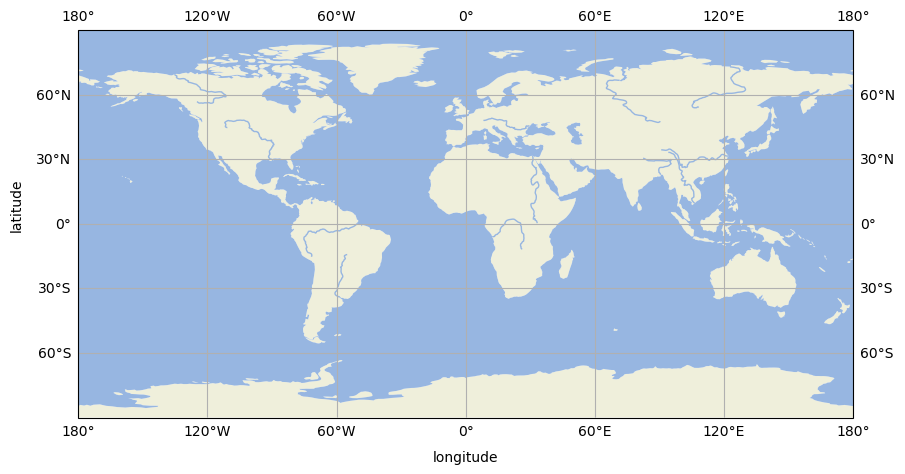

In [37]:
fig = plt.figure(figsize=[10,8])
# What are the units of the figure size? Try to find out.
#
# Geographic maps can have different projection system. 
# Now, we will specify that we want the axes of our figure in PlateCarree projection.
# We won't go into details of projection 


map_projection = ccrs.PlateCarree()
ax = plt.axes(projection=map_projection)
ax.set_extent([-180, 180, -90, 90]) # setting the borders of our map

# adding features to our map
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.COASTLINE)

ax.add_feature(cfeature.RIVERS)
gridlines = ax.gridlines(draw_labels=True)

#gridlines.left_labels = False
#gridlines.top_labels = False

## Note: Normal labeling doesn't work as Cartopy's labeling takeover the matplotlib commands
#ax.set_xlabel('longitude')
#ax.set_ylabel('latitude')

ax.text(-0.07, 0.55, 'latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.12, 'longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes);

In [39]:
ERA_data.t2m.sel(step=ERA_data.step[0]) 

AttributeError: 'Dataset' object has no attribute 'step'

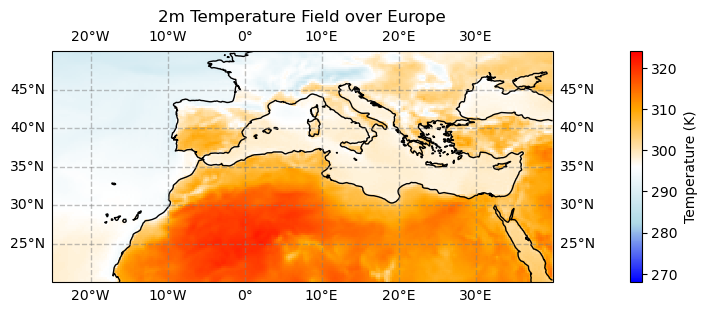

In [14]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'lightblue', 'white', 'orange', 'red'])

# Extract the temperature variable(time _ 0-8759 --> 24h*365d)
temperature = ERA_data.t2m[10,:,:]

# Create a plot with a map of Europe
plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot temperature field
temperature.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature (K)', 'pad': 0.1})
ax.coastlines(resolution='50m')  # Add coastlines
ax.set_extent([-25, 40, 20, 50], crs=ccrs.PlateCarree())  # Set the map extent to Europe
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.title('2m Temperature Field over Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [20]:
# Create own color ramp
cmap = colors.LinearSegmentedColormap.from_list('mycmap', ['blue', 'lightblue', 'white', 'orange', 'red'])

# Extract the temperature variable(time _ 0-8759 --> 24h*365d)
temperature = ERA_data.q[10,:,:]

# Create a plot with a map of Europe
plt.figure(figsize=(10, 3))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot temperature field
temperature.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'label': 'Temperature (K)', 'pad': 0.1})
ax.coastlines(resolution='50m')  # Add coastlines
ax.set_extent([-25, 40, 20, 50], crs=ccrs.PlateCarree())  # Set the map extent to Europe
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
plt.title('2m Temperature Field over Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

AttributeError: Rectangle.set() got an unexpected keyword argument 'cmap'

In [ ]:
# Define the area of interest
area = [75, -35, 35, 40]  # North, West, South, East
temp = ds_temp['t2m']
# Extract the subset for the specified area
temp_area = temp.sel(latitude=slice(area[0], area[2]), longitude=slice(area[1], area[3]))
# Calculate the mean temperature for the area for each time step
mean_temperature = temp_area.mean(dim=('latitude', 'longitude'))

In [ ]:
mean_temperature.plot()
plt.title('Aggregated Mean Temperature for Europe')
plt.xlabel('Time')
plt.ylabel('Mean Temperature (K)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
exp = ds.attrs['experiment_id']
mod = ds.attrs['source_id']

In [ ]:
da = ds['tas']

In [ ]:
weights = np.cos(np.deg2rad(da.lat))
weights.name = "weights"
da_weighted = da.weighted(weights)

In [ ]:
da_agg = da_weighted.mean(['lat', 'lon'])

In [ ]:
da_yr = da_agg.groupby('time.year').mean()

In [ ]:
da_yr = da_yr.assign_coords(model=mod)
da_yr = da_yr.expand_dims('model')
da_yr = da_yr.assign_coords(experiment=exp)
da_yr = da_yr.expand_dims('experiment')

In [ ]:
# daily temperature mean from hourly values
ds.t2m.resample(time='1D').mean()
# daily precipitation sum from hourly values
ds.tp.resample(time='1D').sum()